# <U>Notebook Table Of Contents<u>
**1. CNN multiclass classification method**<br>
&nbsp;&nbsp;&nbsp;&nbsp;1.1 Handling Class Imbalance<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.1.1 Weight Balancing<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.1.2 Using Balanced Dataset<br>
**2. Regression Method - Using continuous output and converting to distinct classes**<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.1 Using Balanced dataset<br>
**3. Performing Stratified K-fold Cross Validation on CNN Models**<br>
**4. Saving CNN models**<br>

In [145]:
#importing numpy and pandas
import numpy as np
import pandas as pd

## plotting modules
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 

#neural network libraries (keras/tensorflow)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.datasets import mnist
from keras.layers import  Conv1D, MaxPooling1D, Conv2D, MaxPool2D, Flatten
from keras import utils
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.utils import class_weight
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

#sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.metrics import classification_report

#supressing warnings
import warnings
warnings.filterwarnings('ignore')

In [146]:
##load in cleaned and processed data
sub_class_data = pd.read_csv('../data/derived_tables/X_y_data/sub_class_data.csv', index_col=0)

#splitting into independent/input (X) and dependent/target (Y) variables
X = sub_class_data.loc[:, sub_class_data.columns != 'sub_class']
y = sub_class_data.loc[:, 'sub_class']

In [147]:
#converting to array of arrays to be compatible with CNN architecture
X = X.values

In [148]:
class_order = set(y)

In [149]:
X.shape, y.shape

((2180, 3508), (2180,))

#### Defining function to split training and testing data

In [150]:
def split_data(X, y):
    #splitting the data into training and testing (80% used for training, 20% for testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = 0.2,
                                                        random_state = 1, 
                                                        stratify = y)
    
    #If data_format="channels_last" (default): input shape is a 3D tensor with shape: 
    #(batch_shape, steps, channels) - https://keras.io/api/layers/convolution_layers/convolution1d/
    #reshaping based on above specification
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, X_test, y_train, y_test

##### Defining some functions to help removing repeated code when evaluating models:

In [151]:
#defining function for evaluating metrics 
def get_metrics(model, X_train, X_test, y_train, y_test, class_type='class'):
    #making predictions from the model on the train and test data
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)
    
    #depending on the classification method used the predictions will need to converted
    if class_type == 'class':
        #need to convert prediction probabilities to predicted classes
        y_preds_train = np.argmax(y_preds_train, axis=1)
        y_preds_test = np.argmax(y_preds_test, axis=1)

        # Convert one-hot encoded variables back to categorical labels
        y_train = np.argmax(y_train, axis=1)
        y_test = np.argmax(y_test, axis=1)
        
    elif class_type == 'reg':
        y_preds_train = y_preds_train.flatten()
        y_preds_test = y_preds_test.flatten()
        #converting continuous predictions to predicted class labels
        y_preds_train = np.round(y_preds_train).astype(int)
        #clipping to ensure predicted class is within the range of available classes
        y_preds_train = np.clip(y_preds_train, 0, len(class_order) - 1)

        y_preds_test = np.round(y_preds_test).astype(int)
        y_preds_test = np.clip(y_preds_test, 0, len(class_order) - 1)
    
    #calculating metrics
    # F1-score
    test_f1 = metrics.f1_score(y_test, y_preds_test, average='weighted')
    train_f1 = metrics.f1_score(y_train, y_preds_train, average='weighted')
    
    #accuracy
    test_accuracy = metrics.accuracy_score(y_test, y_preds_test)
    train_accuracy =  metrics.accuracy_score(y_train, y_preds_train)

    #quadratic weighted kappa
    test_qwk = metrics.cohen_kappa_score(y_test, y_preds_test, weights='quadratic')
    train_qwk = metrics.cohen_kappa_score(y_train, y_preds_train, weights='quadratic')
    #mean absolute error
    test_mae = metrics.mean_absolute_error(y_test, y_preds_test)
    train_mae =  metrics.mean_absolute_error(y_train, y_preds_train)
    
    #getting the class error for test set
    average_error = np.mean(abs(y_test - y_preds_test))
    
    model_metrics = pd.DataFrame({'model':[str(model)], 
                                  'accuracy':[test_accuracy], 
                                  'f1_score':[test_f1],
                                  'QWK':[test_qwk], 
                                  'MAE':[test_mae],
                                   'sp_class_error':[average_error]})

    return model_metrics, y_preds_train, y_preds_test

In [152]:
#defining function to plot scatter plot
def plot_scatter_plot(y_test, y_pred, model_name):
    #adding 5 to each prediction due to 5 missing classes (i.e O0 - O4) when encoding
    class_results = pd.DataFrame({'actual_sub_class':y_test + 5, 
                                       'predicted_sub_class':y_pred + 5})
    
    #determining the density of each prediction/actual combintation 
    results = class_results.groupby(['actual_sub_class', 'predicted_sub_class']).size().reset_index(name='counts')
    
    plt.figure(figsize=(12,8))
    
    scatter_plot = sns.scatterplot(data=results, x='predicted_sub_class', y='actual_sub_class',
                                   hue='counts',palette='dark:blue_r', label='predictions', legend=None)
    
    plt.plot([0,70],[0,70],
             color='red', linestyle='--', linewidth=1, label='true positive diagonal')
    
    mk_classes = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
    tick_positions = [0, 10, 20, 30, 40, 50, 60]
    plt.xticks(tick_positions, mk_classes)
    plt.yticks(tick_positions, mk_classes)
    
    plt.title(f'Scatter plot of actual sub-class index vs predicted sub-class for : {model_name}', fontsize=15)
    plt.ylabel('Actual sub class', fontsize=15)
    plt.xlabel('Predicted sub class', fontsize=15)
    plt.legend(loc=(1.01,0.9))
    plt.grid(True, alpha = 0.4)
    plt.xlim(0,70)
    plt.ylim(0,70)
    plt.show()

# 1. CNN multiclass classification method

**The categorical values (i.e. target variables) need to be one hot encoded in order to work with Neural Networks for multiclass classification. - Frameworks like Keras require the labels to be binarized and have the same dimension as the number of classes.**

In [153]:
#one hot encoding y variable
y_class = np.array(y)
y_class = to_categorical(y_class)

In [154]:
#splitting the training/testing data
X_train, X_test, y_train, y_test = split_data(X, y_class)

**NOTE**: the notebook *CNN_Tuning.ipynb* Section 2, using google colab was used to tune the CNN architecture and hyperparameters resulting in the below model (section 1):

- CNN layer 1: filters = 32, kernel = 3, strides = 1, activation = relu
- CNN layer 2: filters = 64, kernel = 5, strides = 2, activation = relu
- maxpooling size = 2
- Dense layer = 128 neurons
- optimizer = Adam
- learning rate = 0.001 (default)
- batch size = 32

In [155]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1744, 3508, 1), (1744, 64), (436, 3508, 1), (436, 64))

In [156]:
#defining function to compile and run model
def run_cnn(X_train, X_test, y_train, y_test):
    model = models.Sequential()
    model.add(Conv1D(32, kernel_size=3, strides=1, padding='valid', activation='relu', input_shape=(X_test.shape[1], 1)))
    model.add(layers.Conv1D(64,  kernel_size=5, strides=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    #Flatten output of conv
    model.add(layers.Flatten())

    # Fully connected Network as classifier
    # Hidden layer with tunable number of units
    model.add(Dense(128, activation='relu'))

    # Output layer
    model.add(layers.Dense(y_train.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    #setting early stopping to halt epochs if model has reached max accuracy
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)

    model_history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0,
                              validation_data=(X_test, y_test), callbacks=[early_stopping_cb])
    return model, model_history

In [157]:
cnn_model_sub, model_history = run_cnn(X_train, X_test, y_train, y_test)

In [158]:
cnn1_metrics, y_preds_train_cnn, y_preds_test_cnn = get_metrics(cnn_model_sub, X_train, X_test,
                                                  y_train, y_test, class_type='class')

14/14 [==============================] - 0s 16ms/step


In [71]:
cnn1_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,<keras.src.engine.sequential.Sequential object...,0.5,0.490164,0.992012,0.961009,0.961009


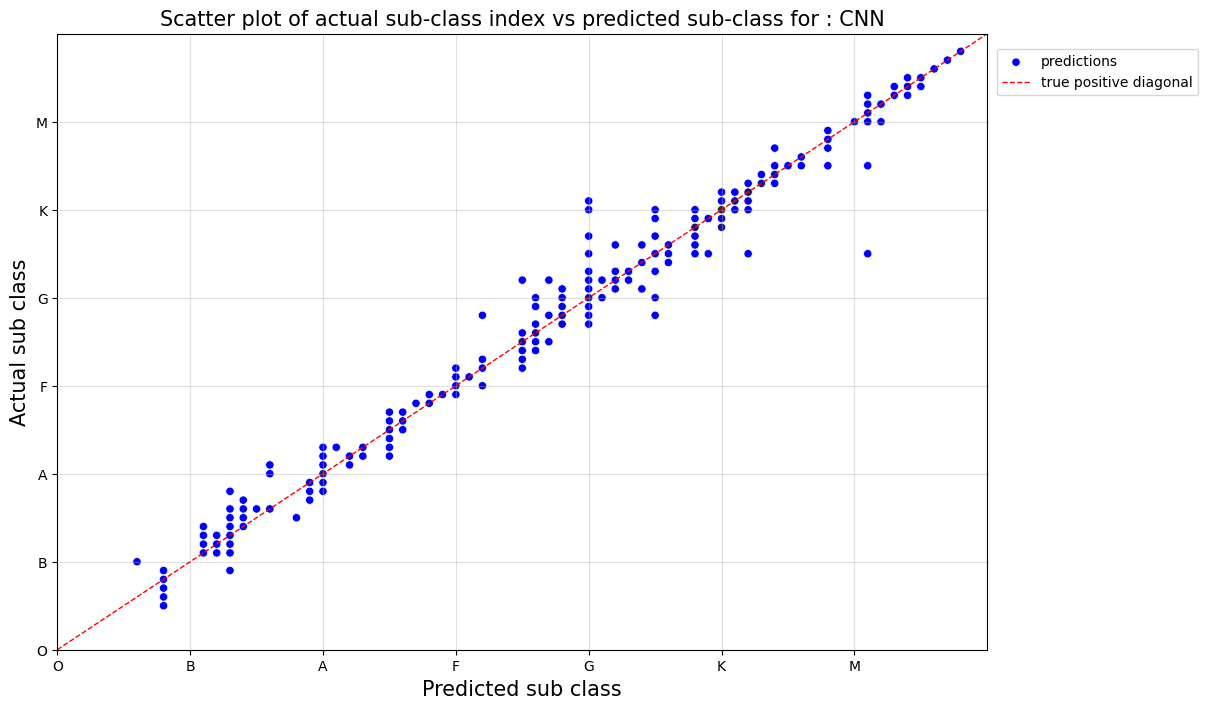

In [159]:
plot_scatter_plot(np.argmax(y_test, axis=1), y_preds_test_cnn, 'CNN')

## 1.1 Handling Class Imbalance

### 1.1.1 Weight Balancing

In [160]:
#creating weights for each class so that they are "balanced" 
#(the smaller a class is the larger the weight)
class_weights = class_weight.compute_class_weight('balanced',
                                                   classes = np.unique(np.argmax(y_train,axis=1)),
                                                   y = np.argmax(y_train,axis=1))

In [161]:
class_weight_dict = dict(enumerate(class_weights))
#class_weight_dict

In [162]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1744, 3508, 1), (1744, 64), (436, 3508, 1), (436, 64))

In [163]:
def run_cnn_weighted(X_train, X_test, y_train, y_test): 
    model = models.Sequential()
    model.add(Conv1D(32, kernel_size=3, strides=1, padding='valid', activation='tanh', input_shape=(X_test.shape[1], 1)))
    model.add(layers.Conv1D(64,  kernel_size=5, strides=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    #Flatten output of conv
    model.add(layers.Flatten())

    # Fully connected Network as classifier
    # Hidden layer with tunable number of units
    model.add(Dense(128, activation='relu'))

    # Output layer
    model.add(layers.Dense(y_train.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    #setting early stopping to halt epochs if model has reached max accuracy
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)

    model_history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0,
                          validation_data=(X_test, y_test), callbacks=[early_stopping_cb],
                          class_weight=class_weight_dict)
    return model, model_history

In [164]:
cnn_model_cl_weights, model_history = run_cnn_weighted(X_train, X_test, y_train, y_test)

In [165]:
cnn_cl_weights_metrics, y_preds_train_cnn, y_preds_test_cnn = get_metrics(cnn_model_cl_weights, X_train, X_test,
                                                               y_train, y_test, class_type='class')

14/14 [==============================] - 0s 17ms/step


In [73]:
cnn_cl_weights_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,<keras.src.engine.sequential.Sequential object...,0.424312,0.448403,0.991425,1.084862,1.084862


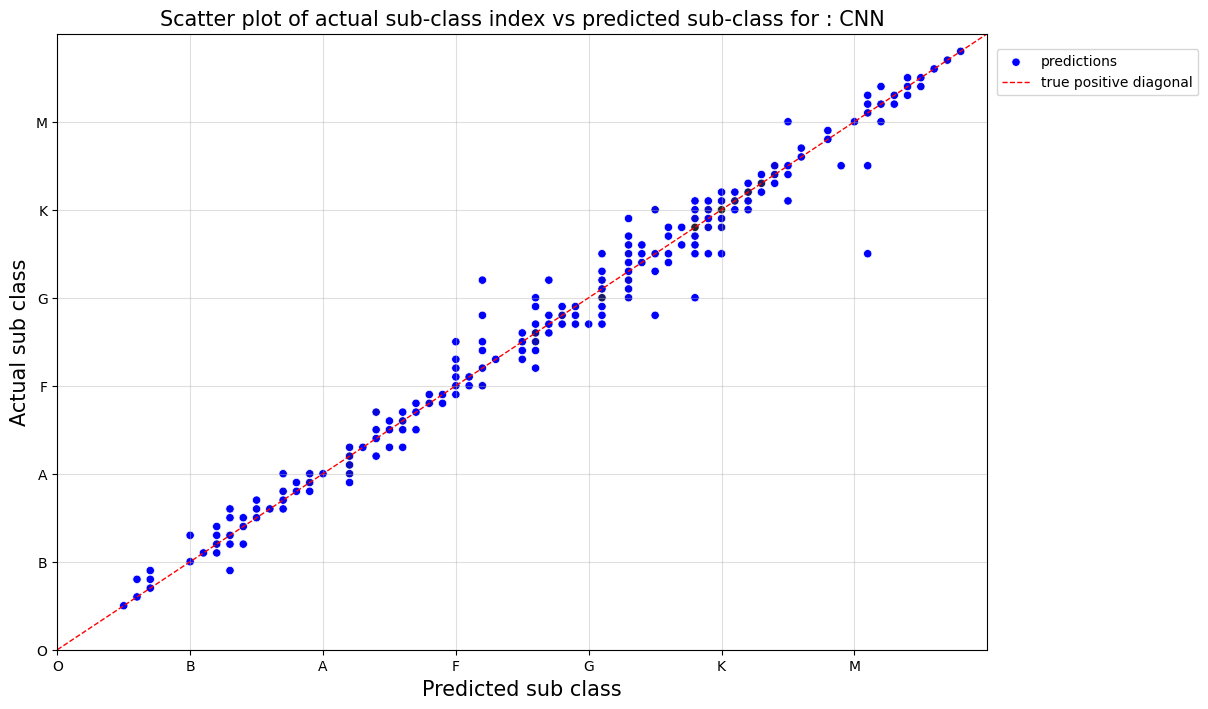

In [166]:
plot_scatter_plot(np.argmax(y_test, axis=1), y_preds_test_cnn, 'CNN')

## 1.1.2 Using Balanced Dataset:

Tuning carried out in Section 2 of colab notebook <I> CNN_Tuning_sub_class.ipynb
    
- layer 1: filters = 32, kernel = 3, strides = 1, activation = relu
- layer 2: filters = 64, kernel = 5, strides = 2, activation = relu
- maxpooling size = 2
- Dense layer = 128 neurons, 64 neurons, 64 neurons
- optimizer = Adam
- learning rate = 0.001 (default)
- batch size = 32

In [167]:
##load in cleaned and processed balanced data
balanced_df = pd.read_csv('../data/derived_tables/X_y_data/sub_bal.csv', index_col=0)

In [168]:
#splitting into independent/input (X) and dependent/target (Y) variables
X_bal = balanced_df.loc[:, balanced_df.columns != 'sub_class']
y_bal = balanced_df.loc[:, 'sub_class']

In [169]:
X_bal = X_bal.values

In [170]:
X_bal.shape, y_bal.shape

((2176, 3508), (2176,))

In [171]:
#one hot encoding y variable
y_class = np.array(y_bal)
y_class = to_categorical(y_class)

In [172]:
#splitting the training/testing data
X_train_bal, X_test_bal, y_train_bal, y_test_bal = split_data(X_bal, y_class)

In [173]:
#looking at shapes
X_train_bal.shape, X_test_bal.shape, y_train_bal.shape, y_test_bal.shape

((1740, 3508, 1), (436, 3508, 1), (1740, 64), (436, 64))

In [174]:
def run_cnn_bal(X_train, X_test, y_train, y_test):
    model = models.Sequential()
    model.add(Conv1D(32, kernel_size=3, strides=1, padding='valid', activation='relu', input_shape=(X_test.shape[1], 1)))
    model.add(layers.Conv1D(64,  kernel_size=5, strides=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    #Flatten output of conv
    model.add(layers.Flatten())

    # Fully connected Network as classifier
    # Hidden layer with tunable number of units
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    
    # Output layer
    model.add(layers.Dense(y_train.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    #setting early stopping to halt epochs if model has reached max accuracy
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)

    model_history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0,
                              validation_data=(X_test, y_test), callbacks=[early_stopping_cb])
    return model, model_history

In [175]:
#running model with balanced data
cnn_model_bal, model_history = run_cnn_bal(X_train_bal, X_test, y_train_bal, y_test)

In [176]:
cnn_bal_metrics, y_preds_train_cnn, y_preds_test_cnn = get_metrics(cnn_model_bal,
                                                  X_train_bal, X_test, y_train_bal, y_test, 
                                                  class_type='class')

14/14 [==============================] - 0s 15ms/step


In [75]:
cnn_bal_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,<keras.src.engine.sequential.Sequential object...,0.571101,0.66194,0.993359,0.754587,0.754587


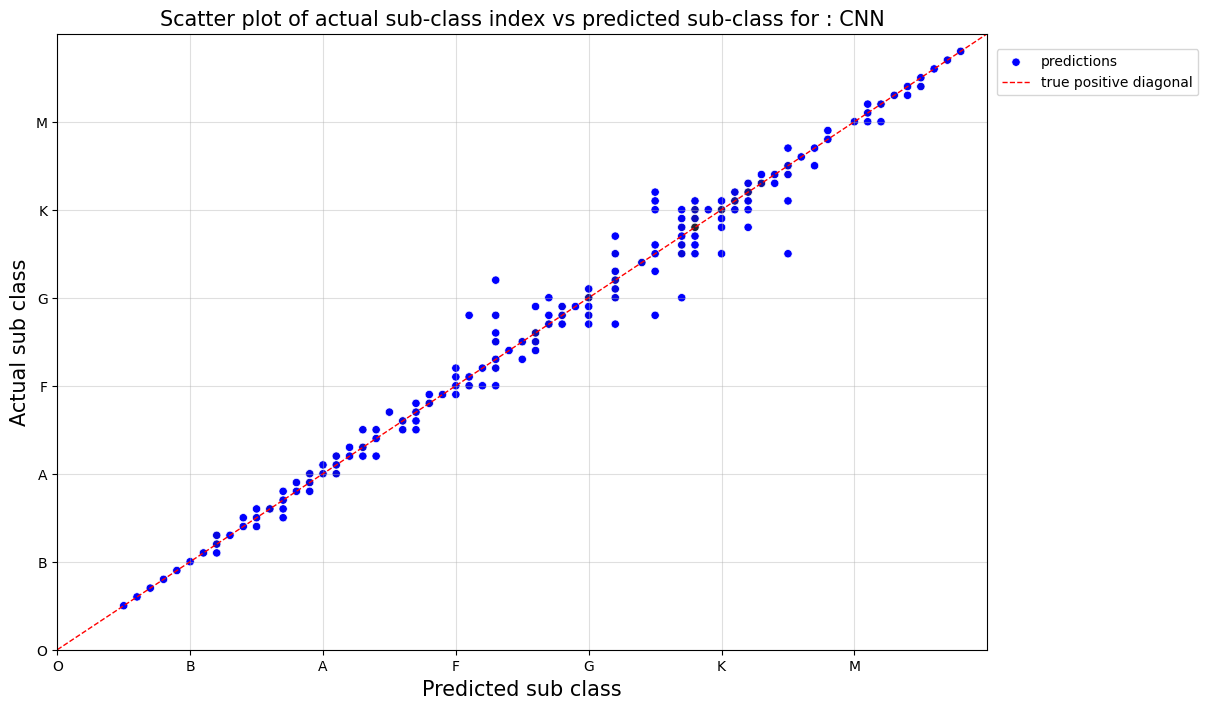

In [177]:
plot_scatter_plot(np.argmax(y_test, axis=1), y_preds_test_cnn, 'CNN')

--------
# 2. Regression Method - Using continuous output and converting to distinct classes

In [178]:
X_train, X_test, y_train, y_test = split_data(X, y)

In [179]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1744, 3508, 1), (436, 3508, 1), (1744,), (436,))

Tuning carried out in Section 3 of colab notebook <I> CNN_Tuning_sub_class.ipynb

- layer 1: filters = 32, kernel = 7, strides = 1, activation = relu
- maxpooling size = 2
- layer 2: filters = 64, kernel = 7, strides = 1, activation = relu
- layer 3: filters = 128, kernel = 3,strides = 1, activation = relu
- Dropout rate 0.3
- Dense layer = 128 neurons, 64 neurons, 24 neurons
- optimizer = Adam
- learning rate = 0.001 (default)
- batch size = 32

In [180]:
def run_cnn_reg(X_train, X_test, y_train, y_test):
    model = models.Sequential()
    model.add(layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='valid', activation='relu', 
                            input_shape=(X_test.shape[1], 1)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=64, kernel_size=7, strides=1, padding='valid', activation='relu'))
    model.add(layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='valid', activation='relu'))
    model.add(Dropout(0.3))
    #Flatten output of conv
    model.add(layers.Flatten())

    # Fully connected Network as classifier
    # Hidden layer with tunable number of units
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(24, activation='relu'))

      # output layer
    model.add(Dense(1, activation='linear'))

    # Compile model
    model.compile(loss='mean_squared_error', metrics=['mean_absolute_error'], optimizer='adam')
    
    #setting early stopping to halt epochs if model has reached max accuracy
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True)

    model_history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0,
                              validation_data=(X_test, y_test), callbacks=[early_stopping_cb])
    return model, model_history

In [181]:
cnn_model_reg, model_history = run_cnn_reg(X_train, X_test, y_train, y_test)

In [182]:
cnn_reg_metrics, y_preds_train_cnn, y_preds_test_cnn = get_metrics(cnn_model_reg, 
                                                  X_train, X_test, y_train, y_test,
                                                  class_type='reg')

14/14 [==============================] - 1s 44ms/step


In [77]:
cnn_reg_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,<keras.src.engine.sequential.Sequential object...,0.272936,0.310618,0.990851,1.334862,1.334862


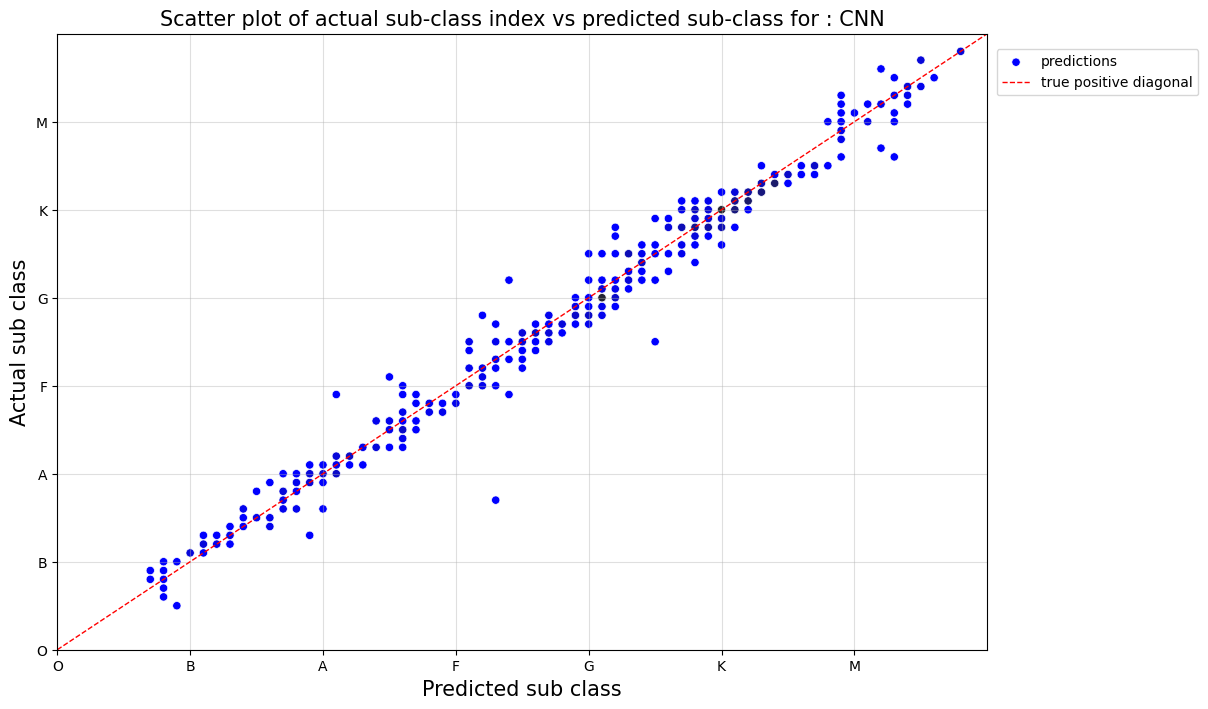

In [183]:
plot_scatter_plot(y_test, y_preds_test_cnn, 'CNN')

### 2.1 Using Balanced dataset

In [184]:
##load in cleaned and processed balanced data
balanced_df = pd.read_csv('../data/derived_tables/X_y_data/sub_bal.csv', index_col=0)

In [185]:
#splitting into independent/input (X) and dependent/target (Y) variables
X_bal = balanced_df.loc[:, balanced_df.columns != 'sub_class']
y_bal = balanced_df.loc[:, 'sub_class']

In [186]:
X_bal = X_bal.values

In [187]:
X_bal.shape, y_bal.shape

((2176, 3508), (2176,))

In [188]:
#splitting the training/testing data
X_train_bal, X_test_bal, y_train_bal, y_test_bal = split_data(X_bal, y_bal)

In [189]:
X_train_bal.shape, X_test_bal.shape, y_train_bal.shape, y_test_bal.shape

((1740, 3508, 1), (436, 3508, 1), (1740,), (436,))

In [190]:
cnn_model_reg_bal, model_history = run_cnn_reg(X_train_bal, X_test, y_train_bal, y_test)

In [191]:
cnn_reg_bal_metrics, y_preds_train_cnn, y_preds_test_cnn = get_metrics(cnn_model_reg_bal, 
                                                                       X_train_bal, X_test, y_train_bal, y_test,
                                                                       class_type='reg')

14/14 [==============================] - 1s 41ms/step


In [134]:
cnn_reg_bal_metrics

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,<keras.src.engine.sequential.Sequential object...,0.133028,0.130552,0.980816,2.222477,2.222477


------------
# 3. Performing Stratified K-fold Cross Validation on CNN Models:

In [168]:
#one hot encoding y variable
y = np.array(y)
y = to_categorical(y)

In [192]:
def get_cross_val_score(model_name, X, y):

    s_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    f1, accuracy, qwk, mae, average_error = [], [], [], [], []
    
    #creating the train/test split
    for train_index, test_index in s_kfold.split(X, np.argmax(y, axis=1)):
        X_train, X_test = X[train_index], X[test_index]
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        
        #initialising models
        if model_name == 'cnn':
            #splitting the data
            y_train, y_test = y_class[train_index], y_class[test_index]
            #runnning model
            model, model_history = run_cnn(X_train, X_test, y_train, y_test)
       
        elif model_name == 'cnn_bal':
            #splitting the data
            y_train, y_test = y_class[train_index], y_class[test_index]
            #runnning model
            model, model_history = run_cnn_bal(X_train, X_test, y_train, y_test)
            
        elif model_name == 'cnn_reg':
            y_train, y_test = y[train_index], y[test_index]
            model, model_history = run_cnn_reg(X_train, X_test, y_train, y_test)
        
        elif model_name == 'cnn_reg_bal':
            y_train, y_test = y[train_index], y[test_index]
            model, model_history = run_cnn_reg(X_train, X_test, y_train, y_test)
            
        #making predictions from the model on the train and test data
        y_preds_train = model.predict(X_train)
        y_preds_test = model.predict(X_test)
        
        if model_name[-3:] == 'reg':
            y_preds_train = y_preds_train.flatten()
            y_preds_test = y_preds_test.flatten()
            #converting continuous predictions to predicted class labels
            y_preds_train = np.round(y_preds_train).astype(int)
            #clipping to ensure predicted class is within the range of available classes
            y_preds_train = np.clip(y_preds_train, 0, len(class_order) - 1)

            y_preds_test = np.round(y_preds_test).astype(int)
            y_preds_test = np.clip(y_preds_test, 0, len(class_order) - 1)
        else: 
            #need to convert prediction probabilities to predicted classes
            y_preds_train = np.argmax(y_preds_train, axis=1)
            y_preds_test = np.argmax(y_preds_test, axis=1)

            # Convert one-hot encoded variables back to categorical labels
            y_train = np.argmax(y_train, axis=1)
            y_test = np.argmax(y_test, axis=1)
        print(y_test)
        print(y_preds_test)
        
        #calculating metrics
        # F1-score
        f1.append(metrics.f1_score(y_test, y_preds_test, average='weighted'))
        #accuracy
        accuracy.append(metrics.accuracy_score(y_test, y_preds_test))
        #quadratic weighted kappa
        qwk.append(metrics.cohen_kappa_score(y_test, y_preds_test, weights='quadratic'))
        #mean absolute error
        mae.append(metrics.mean_absolute_error(y_test, y_preds_test))
        #getting the class error for test set
        average_error.append(np.mean(abs(y_test - y_preds_test)))
    
    model_metrics = pd.DataFrame({'model':[model_name], 
                                  'accuracy':[np.mean(accuracy)], 
                                  'f1_score':[np.mean(f1)],
                                  'QWK':[np.mean(qwk)], 
                                  'MAE':[np.mean(mae)],
                                  'sp_class_error':[np.mean(average_error)]})
    return model_metrics

In [83]:
#running for all cnn models
cnn_df = get_cross_val_score('cnn', X, y)
cnn_bal_df = get_cross_val_score('cnn_bal', X_bal, y_bal)
cnn_reg_df = get_cross_val_score('cnn_reg', X, y)
cnn_reg_bal_df = get_cross_val_score('cnn_reg_bal', X_bal, y_bal)

In [209]:
nn_comparison_df = pd.concat([cnn_df, cnn_bal_df, cnn_reg_df, cnn_reg_bal_df])
nn_comparison_df = nn_comparison_df.reset_index().drop(columns=['index'])

In [141]:
nn_comparison_df 

,model,accuracy,f1_score,QWK,MAE,sp_class_error
0,cnn,0.524404,0.520275,0.991354,1.059633,1.059633
1,cnn_bal,0.603655,0.634361,0.993052,0.736563,0.736563
2,cnn_reg,0.272936,0.310618,0.990851,1.334862,1.334862
3,cnn_reg_bal,0.134117,0.131654,0.980728,2.341361,2.341361


In [142]:
nn_comparison_df.to_csv('../data/derived_tables/model_comparisons/nn_sub_class.csv')

# 4. Saving CNN models:

In [60]:
cnn_model_bal.save('saved_models/cnn_model_sub_bal.h5')
cnn_model_sub.save('saved_models/cnn_model_sub.h5')